In [2071]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import metrics
from sklearn.pipeline import make_pipeline

In [2072]:
#Importing the data
house_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### EDA on training Data

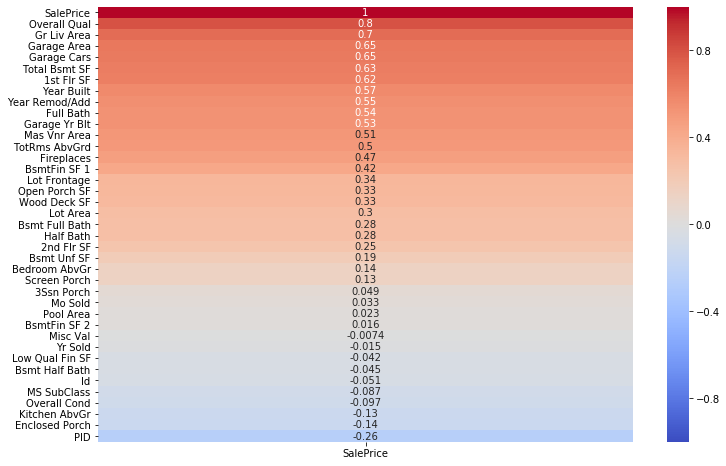

In [2073]:
#Checking the correlation map searching for the most relevant predictors of sale price
focus = house_df.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False)
plt.figure(figsize = (12,8))
sns.heatmap(focus, annot = True, cmap = 'coolwarm', vmin = -1);

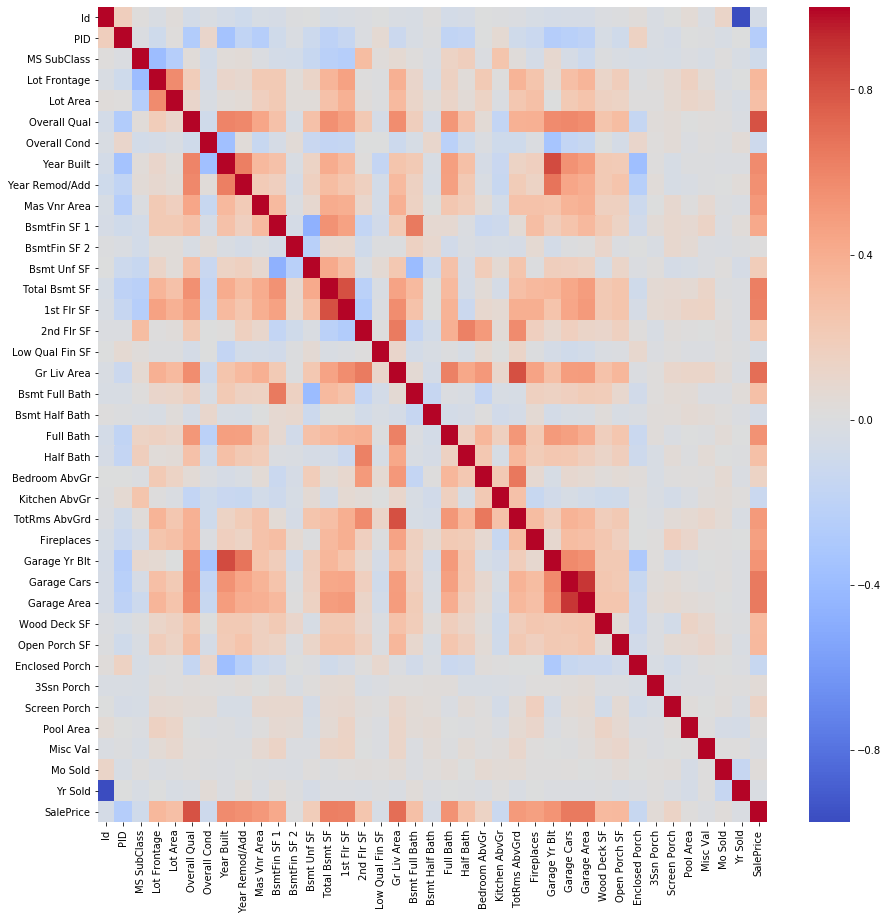

In [2074]:
#Finding Highly Intercorrelated Values
plt.figure(figsize=(15,15))
sns.heatmap(house_df.corr(), annot = False, cmap = 'coolwarm');

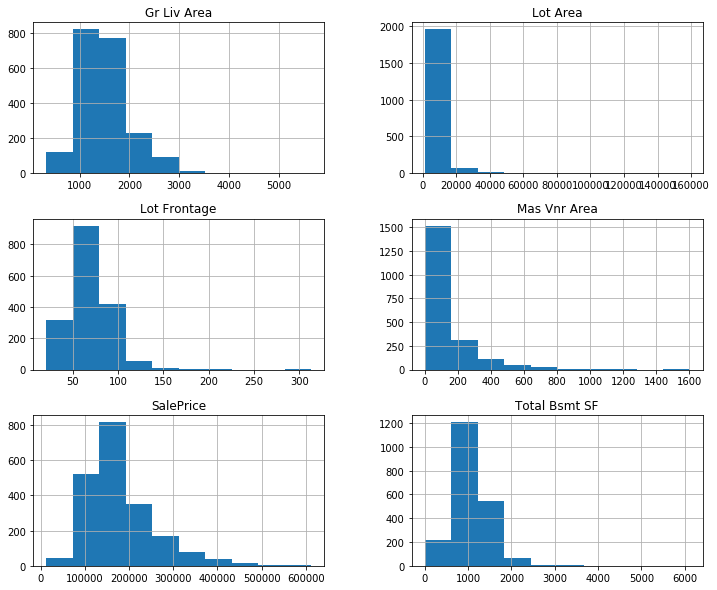

In [2075]:
#Histograms of some important features
house_df[['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area', 'SalePrice']].hist(figsize = (12,10));

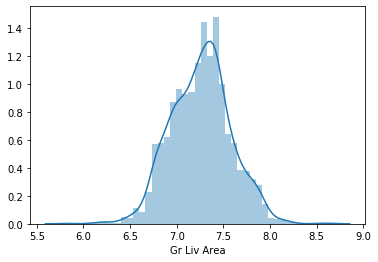

In [2076]:
#Showing what can be done through Logging
sns.distplot(np.log(house_df['Gr Liv Area']));

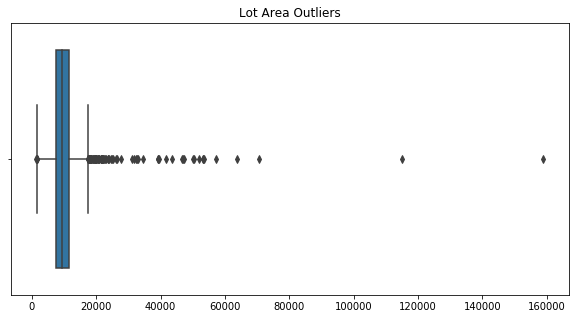

In [2077]:
#Finding Outliers in the data
plt.figure(figsize= (10,5))
sns.boxplot(data = house_df, x = ['Lot Area'])
plt.title('Lot Area Outliers');

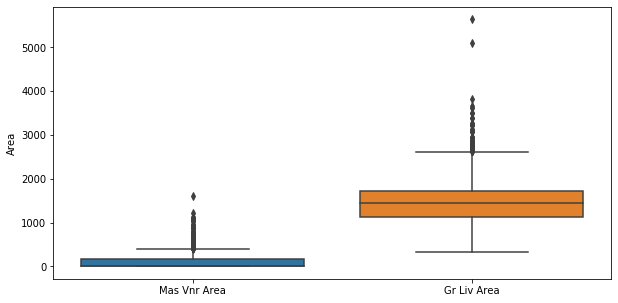

In [2078]:
#Two other parameters with evidently visible outliers
plt.figure(figsize= (10,5))
sns.boxplot(data= (house_df['Mas Vnr Area'], 
                   house_df['Gr Liv Area']));
plt.ylabel('Area')
plt.xticks((np.arange(2)), ('Mas Vnr Area', 'Gr Liv Area' ));

In [2079]:
#Columns which have positive correlations to SalePrice
b = house_df.corr()[['SalePrice']]
b[b['SalePrice'] > 0].index

Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Mo Sold', 'SalePrice'],
      dtype='object')

In [2080]:
#Dropping outliers from the training data set
house_df = house_df[(house_df['Gr Liv Area']<4000) & (house_df['Lot Area']<60000)]

In [2081]:
#Combining the data for Get Dummies
housing_df = pd.concat([house_df, test_df], sort = False, ignore_index= True)
housing_df.drop(columns = ['SalePrice'], inplace = True)

In [2082]:
#Checking the number of columns in the dataset
n_cols = len(housing_df.columns)
print(f'The number of columns in the dataset is {n_cols}')

The number of columns in the dataset is 80


In [2083]:
#Removing columns which have a lot of missing values
miss_columns = housing_df.isnull().sum()[housing_df.isnull().sum()>=1000].index
print (miss_columns)
#Dropping these columns
housing_df.drop(columns = miss_columns, inplace = True)

Index(['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature'], dtype='object')


In [2084]:
#Checking how the dataframe looks
housing_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type
0,109,533352170,60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,...,0,44,0,0,0,0,0,3,2010,WD
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,...,0,74,0,0,0,0,0,4,2009,WD
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,...,0,52,0,0,0,0,0,1,2010,WD
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,...,100,0,0,0,0,0,0,4,2010,WD
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,...,0,59,0,0,0,0,0,3,2010,WD


In [2085]:
#Dropping ID columns which are unique keys
housing_df.drop(columns = ['Id', 'PID'], inplace = True)

In [2086]:
#Filling Null values appropriately

#Handling null values in the following
housing_df['Lot Frontage'].fillna(0, inplace = True)
housing_df['Electrical'].fillna(method = 'ffill', inplace = True)

#Handling null values in Garages
housing_df['Garage Type'].fillna('No_Garage', inplace = True)
housing_df['Garage Yr Blt'].fillna(0, inplace = True)
housing_df['Garage Qual'].fillna('No_Garage', inplace = True)
housing_df['Garage Finish'].fillna('No_Garage', inplace = True)
housing_df['Garage Cond'].fillna('No_Garage', inplace = True)
housing_df['Garage Cars'].fillna(0, inplace = True)
housing_df['Garage Area'].fillna(0, inplace = True)

#Handling null values in Vnr
housing_df['Mas Vnr Type'].fillna('No_Vnr', inplace = True)
housing_df['Mas Vnr Area'].fillna(0, inplace = True)

#Handling null values in Bsmt
housing_df['Bsmt Qual'].fillna('No_Basement', inplace = True)
housing_df['Bsmt Cond'].fillna('No_Basement', inplace = True)
housing_df['BsmtFin Type 1'].fillna('No_Basement', inplace = True)
housing_df['BsmtFin Type 2'].fillna('No_Basement', inplace = True)
housing_df['Bsmt Exposure'].fillna('No_Basement', inplace = True)
housing_df['BsmtFin SF 1'].fillna(0, inplace = True)
housing_df['BsmtFin SF 2'].fillna(0, inplace = True)
housing_df['Total Bsmt SF'].fillna(0, inplace = True)
housing_df['Bsmt Full Bath'].fillna(0, inplace = True)
housing_df['Bsmt Half Bath'].fillna(0, inplace = True)
housing_df['Bsmt Unf SF'].fillna(0, inplace = True)

In [2087]:
# # #Converting skewed data from the EDA into Log
# housing_df[['Lot Frontage', 
#             'Lot Area', 
#             'Mas Vnr Area', 
#             'Total Bsmt SF', 
#             'Gr Liv Area']] = np.log(housing_df[['Lot Frontage',
#                                                  'Lot Area',
#                                                  'Mas Vnr Area', 
#                                                  'Total Bsmt SF',
#                                                  'Gr Liv Area']])

In [2088]:
# #Checking these columns
# housing_df[['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area']].head()

In [2089]:
#Checking for prevalance of any more null values
housing_df.isnull().sum().sum()

0

In [2090]:
#Getting a list of categorical Columns
cat_cols = []
for i in housing_df.columns:
    if housing_df[i].dtype == 'object':
        cat_cols.append(i)
print (f'The number of categorical columns in the dataset is {len(cat_cols)}')

#Creating dummy variables
dummydrop = pd.get_dummies(housing_df[cat_cols], drop_first= True)
print (f'The number of dummy variables created is {len(dummydrop.columns)}')

The number of categorical columns in the dataset is 37
The number of dummy variables created is 214


In [2091]:
dummydrop.head()

,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,...,Paved Drive_Y,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [2092]:
#Dropping categorical columns after dummy creation
housing_df.drop(cat_cols,1,inplace = True)

In [2093]:
#Creating the final complete data after EDA changes
preproc = pd.concat([housing_df, dummydrop], 1)
preproc.dropna(inplace =True)

In [2094]:
#Dataframe containing both Training and Test data
print(f'The shape of the final complete dataframe is {preproc.shape}')

The shape of the final complete dataframe is (2925, 250)


In [2095]:
#Splitting the data back into Training and Test data
training_data = preproc[0:len(house_df)]
test_data = preproc[len(house_df):]

In [2096]:
# #Correlation Finder and column excluder
# b = training_data.corr()[['SalePrice']]
# corr_col = b[b['SalePrice'] > 0.2].index
# neg_corr_col = b[b['SalePrice'] < -0.3].index
# joinedList = [*corr_col[:-1], *neg_corr_col]

### Model Creation

In [2097]:
#Models on the Training data
y = house_df['SalePrice']
X = training_data

#Splitting the data
from sklearn.model_selection import train_test_split as ts
X_train, X_test, y_train, y_test = ts(X, y , test_size=0.1, random_state=42)

In [2098]:
#Fitting the linear model
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [2099]:
#Checking rmse score through my method of predictions
pred_linear = lr.predict(X_test)
pred_linear= (np.exp(pred_linear))
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test,pred_linear))
print (rmse_lr)

18207.569506170774


In [2100]:
#Scaling and fitting the data using the standard scaler
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [2101]:
#Instantiating Lasso and Ridge
lasso = LassoCV(cv = 5) 
ridge = RidgeCV(cv = 5)

In [2102]:
#Logging y_train
y_train = np.log(y_train)
y_train = np.nan_to_num(y_train)

In [2103]:
#Checking the cross_val score for Lasso
cross_val_score(lasso, X_train_sc, y_train, cv = 5).mean()

0.9108505557495308

In [2104]:
##Checking the cross_val score for LR
cross_val_score(lr, X_train, y_train, cv =5).mean()

0.9019243802868859

In [2105]:
##Checking the cross_val score for Ridge
cross_val_score(ridge, X_train_sc, y_train, cv =5).mean()

0.9022538595296308

In [2106]:
#Logging y for final training of Lasso
y = np.log(y)
y = np.nan_to_num(y)

In [2107]:
#Scaling and fitting the entire training data to the Lasso Model
ss.fit(X)
X_sc = ss.transform(X)

#Fitting Lasso 
lasso.fit(X_sc, y)

#Scaling test_data
test_data_sc = ss.transform(test_data)

#Making predictions
y_pred_lasso = lasso.predict(test_data_sc)

In [2108]:
# Final output of the model
y_pred_lasso = np.exp(y_pred_lasso)
#Displaying the first 10 predictions
y_pred_lasso[:10]

array([118037.94997051, 160419.48648251, 213662.05032638, 105728.85528634,
       174046.54033484,  96714.00072313, 108155.28486393, 144455.81567468,
       186840.70867741, 165283.69045716])

In [2109]:
#Creating the submission file
y_kaggle_df = pd.DataFrame(index=test_df['Id'], data=y_pred_lasso, columns=['SalePrice'])
y_kaggle_df.to_csv('submission.csv')